In [0]:
#Importing Required libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse

In [0]:
#Setting the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [29]:
#Augmentations on the imput images

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
    #transforms.RandomRotation(degrees=[-10,10], resample=False, expand=False, center=None, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


 ship  bird  ship   dog


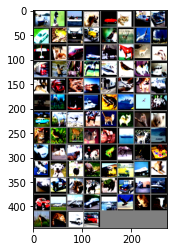

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
#ResNeXt Architecture from scratch


import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    #Grouped convolution block
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(num_blocks[0], 1)
        self.layer2 = self._make_layer(num_blocks[1], 2)
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # self.layer4 = self._make_layer(num_blocks[3], 2)
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNeXt29_2x64d():
    return ResNeXt(num_blocks=[3,3,3], cardinality=2, bottleneck_width=64)

def ResNeXt29_4x64d():
    return ResNeXt(num_blocks=[3,3,3], cardinality=4, bottleneck_width=64)

def ResNeXt29_8x64d():
    return ResNeXt(num_blocks=[3,3,3], cardinality=8, bottleneck_width=64)

def ResNeXt29_32x4d():
    return ResNeXt(num_blocks=[3,3,3], cardinality=32, bottleneck_width=4)

#def test_resnext():
net = ResNeXt29_32x4d()
x = torch.randn(1,3,32,32)
y = net(x)
print(y.size())
   

#test_resnext()


torch.Size([1, 10])


In [32]:
# Model
print('==> Building model..')
net = ResNeXt29_32x4d()
print(net)

==> Building model..
ResNeXt(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): B

In [0]:
#Setting the model on cuda

if torch.cuda.is_available():
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [0]:
#Training the model

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [0]:
#Testing the model

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
  # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


In [36]:
#Implementing Train and Test for 30 epochs

for epoch in range(start_epoch, start_epoch+30):
    train(epoch)
    test(epoch)


Epoch: 0
499 500 Loss: 1.645 | Acc: 40.262% (20131/50000)
99 100 Loss: 1.239 | Acc: 55.430% (5543/10000)
Saving..

Epoch: 1
499 500 Loss: 1.107 | Acc: 60.114% (30057/50000)
99 100 Loss: 1.061 | Acc: 62.720% (6272/10000)
Saving..

Epoch: 2
499 500 Loss: 0.876 | Acc: 68.994% (34497/50000)
99 100 Loss: 0.957 | Acc: 68.050% (6805/10000)
Saving..

Epoch: 3
499 500 Loss: 0.714 | Acc: 75.152% (37576/50000)
99 100 Loss: 0.724 | Acc: 75.730% (7573/10000)
Saving..

Epoch: 4
499 500 Loss: 0.590 | Acc: 79.584% (39792/50000)
99 100 Loss: 0.660 | Acc: 78.060% (7806/10000)
Saving..

Epoch: 5
499 500 Loss: 0.521 | Acc: 82.032% (41016/50000)
99 100 Loss: 0.707 | Acc: 77.810% (7781/10000)

Epoch: 6
499 500 Loss: 0.462 | Acc: 84.304% (42152/50000)
99 100 Loss: 0.619 | Acc: 80.030% (8003/10000)
Saving..

Epoch: 7
499 500 Loss: 0.415 | Acc: 85.772% (42886/50000)
99 100 Loss: 0.523 | Acc: 83.420% (8342/10000)
Saving..

Epoch: 8
499 500 Loss: 0.378 | Acc: 87.042% (43521/50000)
99 100 Loss: 0.510 | Acc: 83.3

####  VALIDATION ACCURACY IS 89.760%

In [0]:
#Number of Parameters

def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Total_params",pytorch_total_params)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable_params",pytorch_total_params)

In [38]:
count_parameters(net)

Total_params 4774218
Trainable_params 4774218


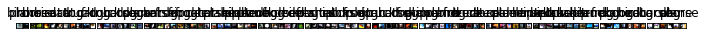

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

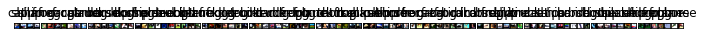

In [40]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [0]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)

In [0]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

In [43]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 1.0000
ship - 0.9995
car - 0.8538
plane - 0.9987
frog - 1.0000
frog - 1.0000
car - 0.9999
frog - 1.0000
cat - 0.9999
car - 0.9968
plane - 0.9893
truck - 1.0000
dog - 0.9958
horse - 1.0000
truck - 1.0000
frog - 0.7086
dog - 0.9983
horse - 0.9998
ship - 1.0000
frog - 1.0000
horse - 0.4561
plane - 0.9888
deer - 0.9983
truck - 1.0000
cat - 0.4698
bird - 0.9997
deer - 0.6759
plane - 0.9982
truck - 1.0000
frog - 0.9998
frog - 0.9954
dog - 0.9987
deer - 0.9796
bird - 0.5577
truck - 1.0000
bird - 0.8838
deer - 1.0000
car - 0.8451
truck - 0.9999
dog - 1.0000
deer - 0.9999
frog - 1.0000
dog - 0.9847
frog - 0.9996
plane - 1.0000
truck - 0.9998
cat - 0.9221
truck - 0.9214
horse - 1.0000
frog - 0.9844
truck - 1.0000
ship - 1.0000
horse - 0.5560
cat - 0.9992
ship - 1.0000
ship - 0.9999
horse - 0.9985
cat - 0.8636
deer - 0.3659
cat - 0.8873
horse - 0.9998
cat - 0.8859
frog - 0.9999
cat - 0.9948
frog - 0.9993
bird - 0.9999
car - 0.9888
bird - 0.9987
cat - 0.4840
horse - 0.9984
plane - 0.4224
fro

In [44]:
#Model Accuracy

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 89.76%


In [45]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 89.9
car        - 97.8
bird       - 89.9
cat        - 86.2
deer       - 90.6
dog        - 74.8
frog       - 94.4
horse      - 87.1
ship       - 94.3
truck      - 92.6


In [46]:
#Confusion Matrix

print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           899       11        35        10        4         1         7         5         18        10        
                0.899     0.011     0.035     0.01      0.004     0.001     0.007     0.005     0.018     0.01      
car             1         978       2         0         0         0         1         0         6         12        
                0.001     0.978     0.002     0.0       0.0       0.0       0.001     0.0       0.006     0.012     
bird            14        0         899       28        18        6         29        3         3         0         
                0.014     0.0       0.899     0.028     0.018     0.006     0.029     0.003     0.003     0.0       
cat             5         3         41        862       18        45        18        5         3         0         
                0.005     0.003     0.041     0.862     0.018   

Ran a lot of different models ,with different learning rates, tried different combinations of augmentations such as changing brightness, hue, jitter, and also normalisation. Experimented on different batch sizes and number of epochs. Also made architecture changes regarding number of blocks to reduce the number of parameters. 

Decisions on how to conitnue further were made by looking at the loss. By analysing loss, we took steps like adding regualrizers to prevent overfitting. You can see all different variations in the excel sheet attached.